## This notebook is split into four sections, the first of which processes the features which have already been generated, while the second performs randomized grid search cross validation with RF, SVM, GBC, MLP, and KNN classifiers. The third section plots an ROC curve, and the fourth section uses the tabular data within a CNN for practice with the Keras/Tensorflow libraries.

### 1) Processing

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import glob
import os.path
import librosa
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import random

#### Import and concatenate data, identify pathological voice samples via the All_Pathologisch.csv. Drop ID column and replace na values with mean of that column.

In [2]:
f_all = pd.read_csv(r'C:\Users\esabic\Desktop\All_F.csv', \
                           index_col = None, header = None) 
m_all = pd.read_csv(r'C:\Users\esabic\Desktop\All_M.csv', \
                           index_col = None, header = None) 

df = pd.concat([f_all, m_all], axis = 0)

all_pathologisch = pd.read_csv(r'C:\Users\esabic\Desktop\All_Pathologisch.csv', \
                           index_col = None, header = None)

for i in range(len(df)):
    current_id = df.iloc[i, -4]
    if current_id in all_pathologisch.values:
            df.iloc[i,-1] = 1 # by default this value is gesund (0)
            
df = df.drop(df.columns[76], axis = 1) # drops ID column
df = df.fillna(df.mean())

#### Scale data and one-hot encode sex and age variables. Returns X dataframe with all processed features and y target array.

In [3]:
scaler = StandardScaler()
scaler.fit(df.iloc[:, 0:76])
df.iloc[:,0:76] = scaler.transform(df.iloc[:, 0:76])

sex_categorical = to_categorical(df.iloc[:,76], num_classes = 2)
age_categorical = to_categorical(df.iloc[:,77], num_classes = 10) 

df = shuffle(df)

y = df.iloc[:,-1]
df = df.drop(df.columns[-1], axis = 1) # drop target

sex_categorical, age_categorical = pd.DataFrame(sex_categorical), pd.DataFrame(age_categorical)

df = df.reset_index(drop = True) # reset all indices for concatenation
sex_categorical = sex_categorical.reset_index(drop = True)
age_categorical = age_categorical.reset_index(drop = True)

df = pd.concat([df, sex_categorical, age_categorical], axis = 1)

X = df

#### Define convenience function for RandomizedSearchCV reports.

In [4]:
def report(results, n_top=3): #utility function to report scores
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### 2) Model Evaluation via Grid Search

#### Random Forest randomized grid search.

In [5]:
rf_clf = RandomForestClassifier()

param_grid = [
    {
        'n_estimators' : [1500],
        'criterion' : ['gini', 'entropy'],
        'max_depth': [None, 2, 4, 6, 8],
        'min_samples_split': [2, 4, 10, 18],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf':[1,3,5,7,9]
    }
]

random_search = RandomizedSearchCV(rf_clf, param_distributions = param_grid, random_state = 0, n_jobs = -1, n_iter = 5)
random_search.fit(X, y)

report(random_search.cv_results_)

{'n_estimators': 1500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}
Model with rank: 1
Mean validation score: 0.822 (std: 0.021)
Parameters: {'n_estimators': 1500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.821 (std: 0.025)
Parameters: {'n_estimators': 1500, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.818 (std: 0.022)
Parameters: {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}



#### Gradient Boosting Regressor randomized grid search.

In [6]:
param_grid = [
    {
        'n_estimators' : [50, 100, 500],
        'criterion' : ['friedman_mse', 'mse', 'mae'],
        'max_depth': [None, 2, 4, 6, 8],
        'min_samples_split': [2, 4, 10, 18],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf':[1,3,5,7,9]
    }
]

gbr_clf = GradientBoostingClassifier()

random_search = RandomizedSearchCV(gbr_clf, param_distributions = param_grid, random_state = 0, n_jobs = -1, n_iter = 5)
random_search.fit(X, y)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.834 (std: 0.020)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'friedman_mse'}

Model with rank: 2
Mean validation score: 0.830 (std: 0.017)
Parameters: {'n_estimators': 50, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'mse'}

Model with rank: 3
Mean validation score: 0.829 (std: 0.018)
Parameters: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'mse'}



#### Multilayer Perceptron randomized grid search.

In [7]:
param_grid = [
    {
        'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [
        (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
        ]
    }
]

mlp_clf = MLPClassifier()

random_search = RandomizedSearchCV(mlp_clf, param_distributions = param_grid, random_state = 0, n_jobs = -1, n_iter = 5)
random_search.fit(X, y)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.811 (std: 0.013)
Parameters: {'solver': 'adam', 'hidden_layer_sizes': (13,), 'activation': 'logistic'}

Model with rank: 2
Mean validation score: 0.807 (std: 0.015)
Parameters: {'solver': 'adam', 'hidden_layer_sizes': (7,), 'activation': 'logistic'}

Model with rank: 3
Mean validation score: 0.800 (std: 0.012)
Parameters: {'solver': 'adam', 'hidden_layer_sizes': (11,), 'activation': 'tanh'}



C:\Users\esabic\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Support Vector Classifier randomized grid search.

In [8]:
param_grid = [
    {
        'C' : [1, .5, .1],
        'kernel' : ['poly','rbf', 'sigmoid'],         
    }
]

svc_clf = SVC()

random_search = RandomizedSearchCV(svc_clf, param_distributions = param_grid, random_state = 0, n_jobs = -1, n_iter = 5)
random_search.fit(X, y)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.831 (std: 0.018)
Parameters: {'kernel': 'rbf', 'C': 1}

Model with rank: 2
Mean validation score: 0.822 (std: 0.021)
Parameters: {'kernel': 'rbf', 'C': 0.5}

Model with rank: 3
Mean validation score: 0.821 (std: 0.017)
Parameters: {'kernel': 'sigmoid', 'C': 0.1}



#### K-Nearest Neighbors randomized grid search.

In [9]:
param_grid = [
    {
        'n_neighbors' : [35, 40, 45],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
]

knn_clf = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn_clf, param_distributions = param_grid, random_state = 0, n_jobs = -1, n_iter = 5)
random_search.fit(X, y)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.810 (std: 0.026)
Parameters: {'n_neighbors': 35, 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: 0.808 (std: 0.024)
Parameters: {'n_neighbors': 40, 'algorithm': 'ball_tree'}

Model with rank: 2
Mean validation score: 0.808 (std: 0.024)
Parameters: {'n_neighbors': 40, 'algorithm': 'brute'}



#### Stacked Classifier evaluation with tuned models.

In [10]:
estimators = [
    ('rf', GradientBoostingClassifier(n_estimators = 50, min_samples_split = 18, min_samples_leaf = 5, max_features = 'auto', \
        max_depth = 8, criterion = 'mse')),
    ('svc', SVC(kernel = 'rbf'))
]

stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

print('Mean accuracy of stacked classifier was... ',np.mean(cross_val_score(stacked_clf, X, y, cv = 5)) * 100)

Mean accuracy of stacked classifier was...  83.58742029819261


#### Ideal hyperparamaters of a recent run for reference:

##### RF: n_estimators = 1500, min_samples_splitt = 18, min_samples_leaf = 7, max_features = 'auto', max_depth = 'None', criterion = 'entropy' <br> GBR: n_estimators = 50, min_samples_splitt = 18, min_samples_leaf = 5, max_features = 'auto', max_depth = 8, criterion = 'mse'<br> MLP: solver = 'adam', hidden_layer_sizes = (13,), activation = 'logistic'<br>SVC: kernel = 'rbf', C = 1<br>KNN: n_neighbors = 40, algorithm = 'ball_tree'

#### Accuracy of a recent run for reference:

##### RF Accuracy: 82.8%, GBR Accuracy: 83.7%, MLP Accuracy: 80.8%, SVC Accuracy: 83.2%, KNN Accuracy: 80.5%, <br> Stacked Classifier Accuracy: 84.1%, Simple Logistic Regression Accuracy: 80.8%




### 3) ROC Curve and Plotting

format: precision, then recall, then F-score... 
 (0.8120173411445653, 0.8140293637846656, 0.8095278647230122, None)


C:\Users\esabic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

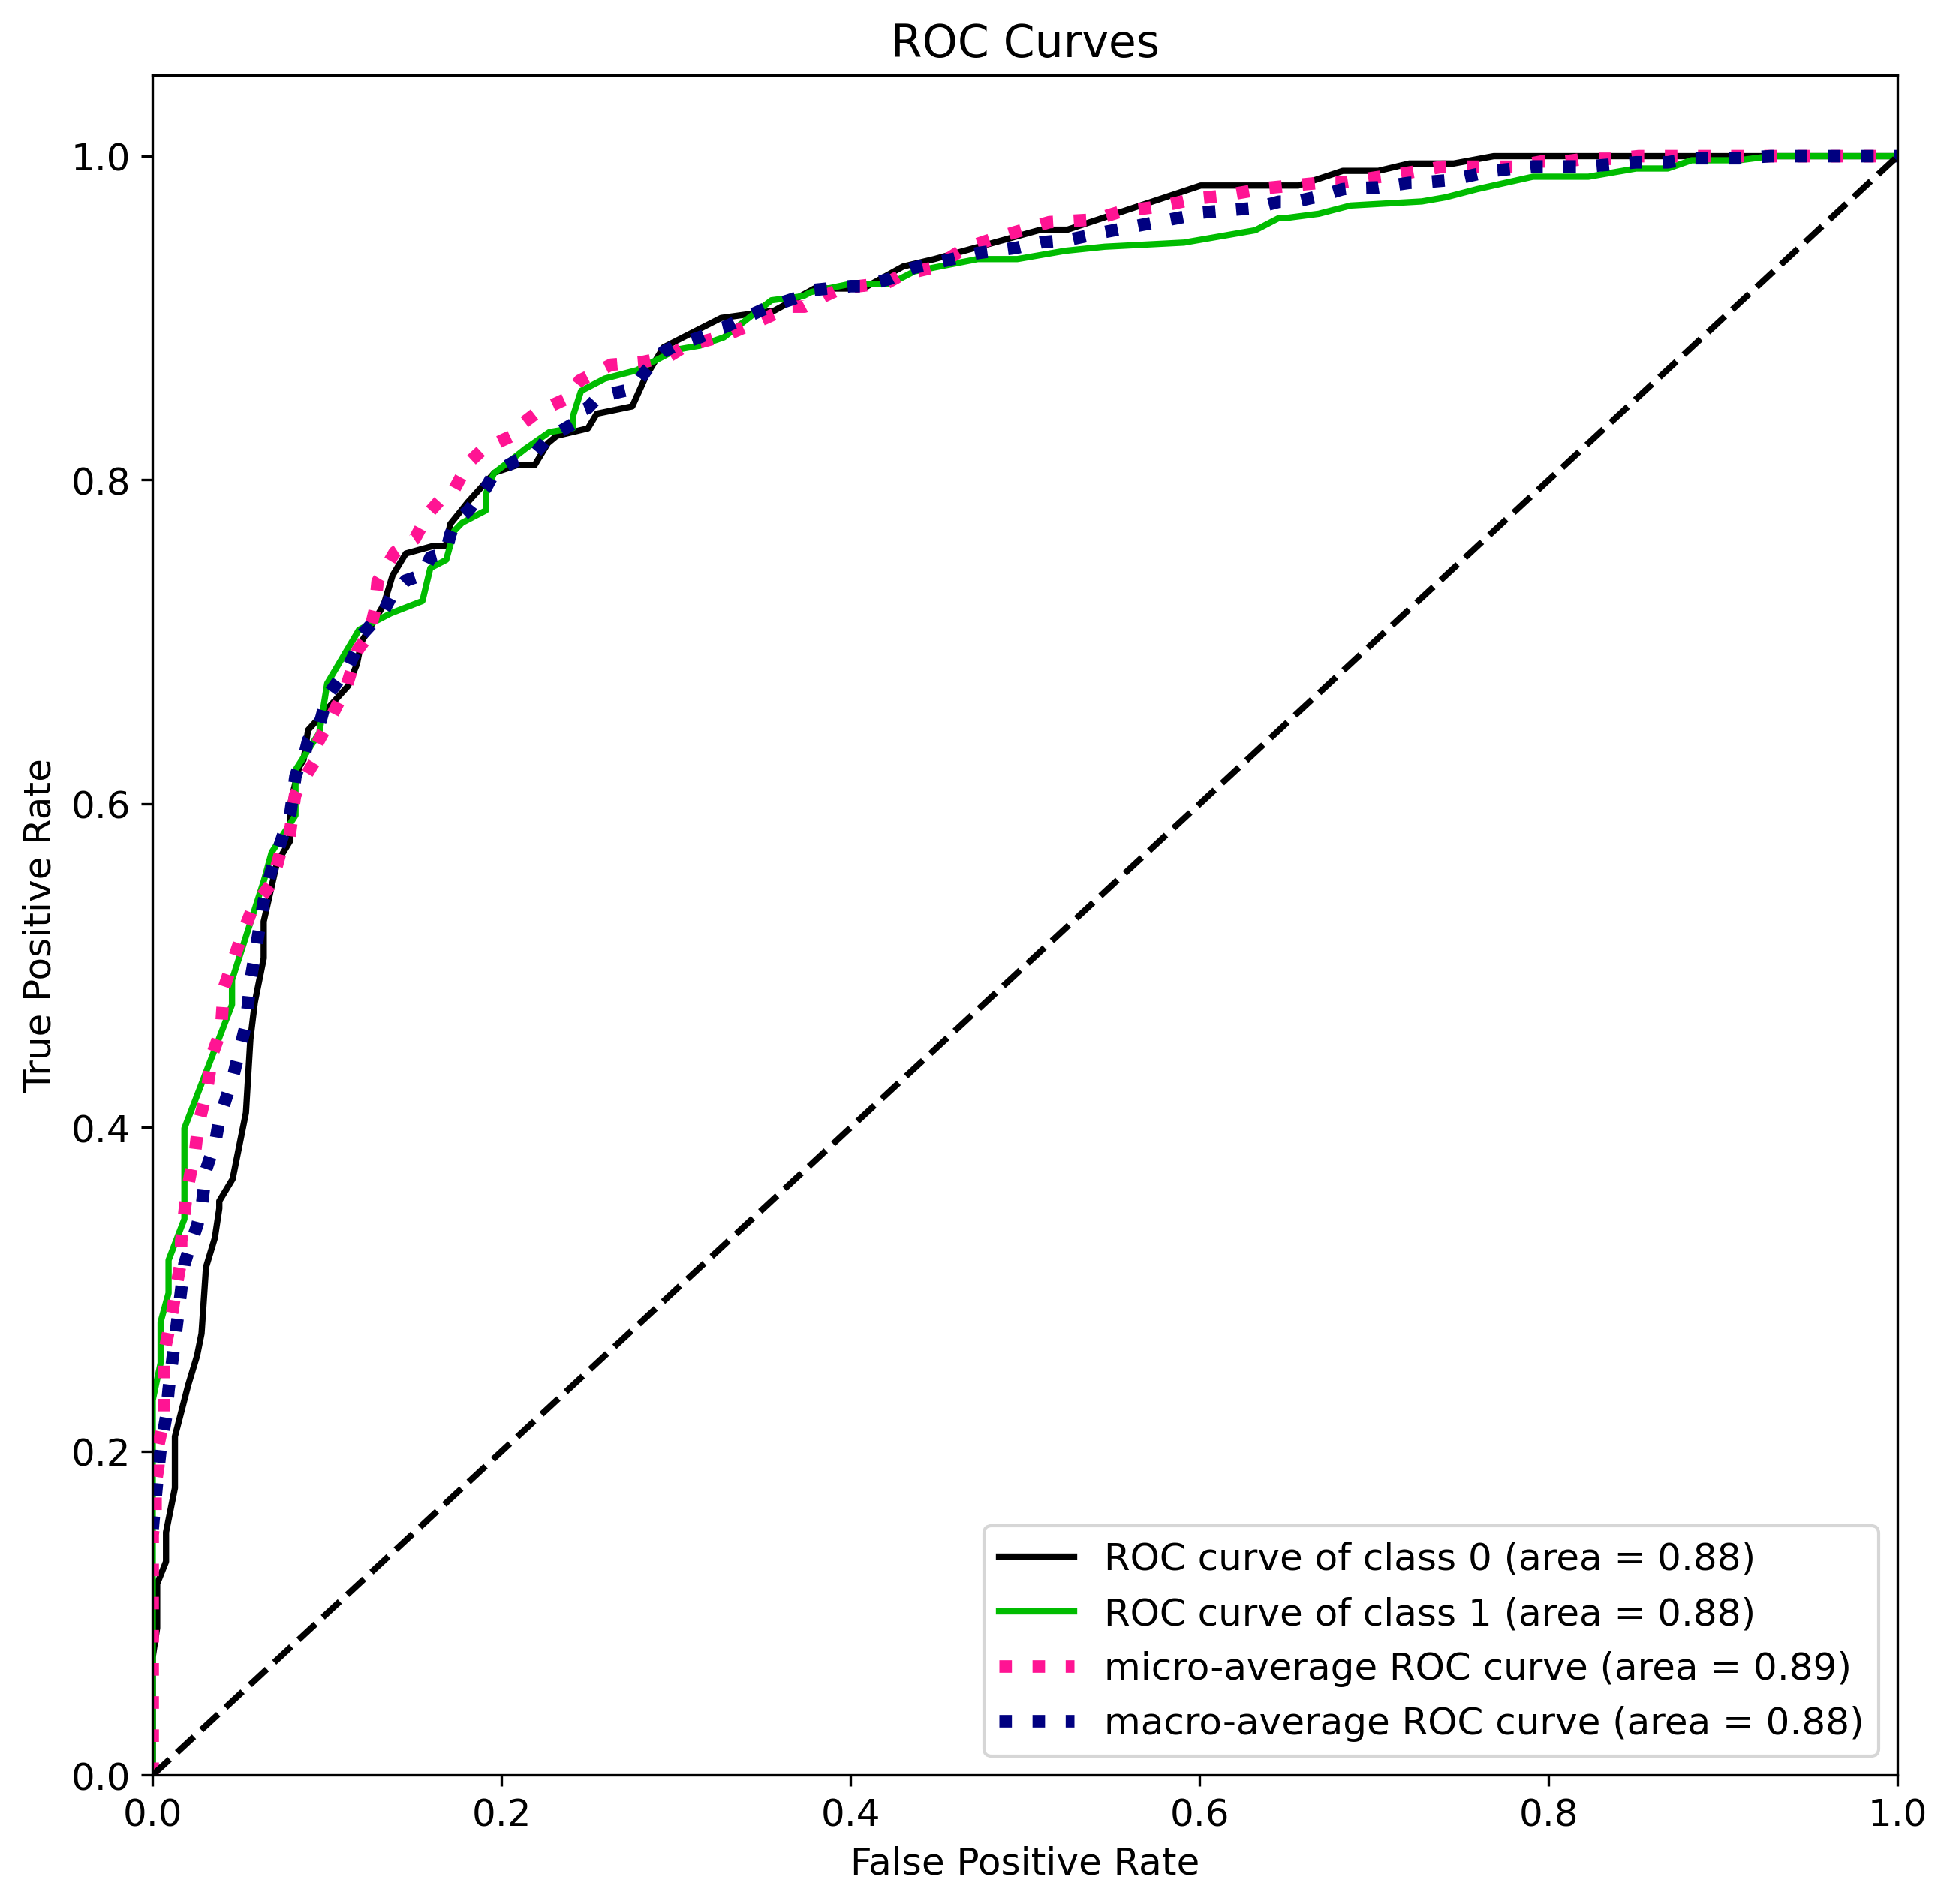

In [11]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

rf_clf.fit(X_train, y_train)
y_probas = rf_clf.predict_proba(X_test)

print('format: precision, then recall, then F-score... \n', precision_recall_fscore_support(y_test, rf_clf.predict(X_test), average = 'weighted'))

from pylab import rcParams
from sklearn.model_selection import train_test_split

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 12

skplt.metrics.plot_roc_curve(y_test, y_probas)

plt.show

### 4) Using the tabular data within a CNN. Here I reshape the data for input into a Keras CNN, and create two plots containing accuracy and loss.

In [12]:
print(X.shape, y.shape)

reshape_X = X.values.reshape(2041, 9, 10)

print(reshape_X.shape)

(2041, 90) (2041,)
(2041, 9, 10)


#### Split the data into train, valid, and test sets via two calls to the train_test_split function. Then, reshape the data (reshaping in this way for later repos that will use image classification tasks on spectrograms where arrays will be 2D).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = .5)

print(X_train.shape, X_valid.shape, X_test.shape)

(1224, 90) (408, 90) (409, 90)


In [ ]:
X_train = X_train.values.reshape(1224, 9, 10, 1)
X_test = X_test.values.reshape(409, 9, 10, 1)
X_valid = X_valid.values.reshape(408, 9, 10, 1)

In [16]:
print(X_train.shape, X_test.shape, X_valid.shape)

(1224, 9, 10, 1) (409, 9, 10, 1) (408, 9, 10, 1)


In [17]:
import glob
import os.path
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import random

model = tf.keras.models.Sequential([ # still experimenting with these hyperparameters...
    tf.keras.layers.Flatten(input_shape = (9,10,1)),
    tf.keras.layers.Dense(220, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.003)),
    tf.keras.layers.Dense(250, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.003)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2) # binary output
])

print('Return a vector of logits (log-odds) scores for each class... ', model(X_train[:1]).numpy())

print(model.summary())

Return a vector of logits (log-odds) scores for each class...  [[-0.5783861   0.22336978]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 90)                0         
_________________________________________________________________
dense (Dense)                (None, 220)               20020     
_________________________________________________________________
dense_1 (Dense)              (None, 250)               55250     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
Total params: 75,772
Trainable params: 75,772
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
predictions = model(X_train[:]).numpy()
tf.nn.softmax(predictions).numpy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:], predictions).numpy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

epochs = 50

history = model.fit(X_train, y_train, epochs = epochs, batch_size = 124, validation_data = (X_valid, y_valid))

model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/50
10/10 [==============================] - 0s 23ms/step - loss: 13.3250 - accuracy: 0.6724 - val_loss: 12.3037 - val_accuracy: 0.7132
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 11.5383 - accuracy: 0.7672 - val_loss: 10.6284 - val_accuracy: 0.7623
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 9.9131 - accuracy: 0.7982 - val_loss: 9.0681 - val_accuracy: 0.7843
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 8.4099 - accuracy: 0.7958 - val_loss: 7.6381 - val_accuracy: 0.8039
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 7.0298 - accuracy: 0.8203 - val_loss: 6.3328 - val_accuracy: 0.8064
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 5.7887 - accuracy: 0.8154 - val_loss: 5.1770 - val_accuracy: 0.8137
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 4.6839 - accuracy: 0.8301 - val_loss: 4.1486 - val_accuracy: 0.8235
Epoch 8/50
10/1

[0.4786146879196167, 0.8264058828353882]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


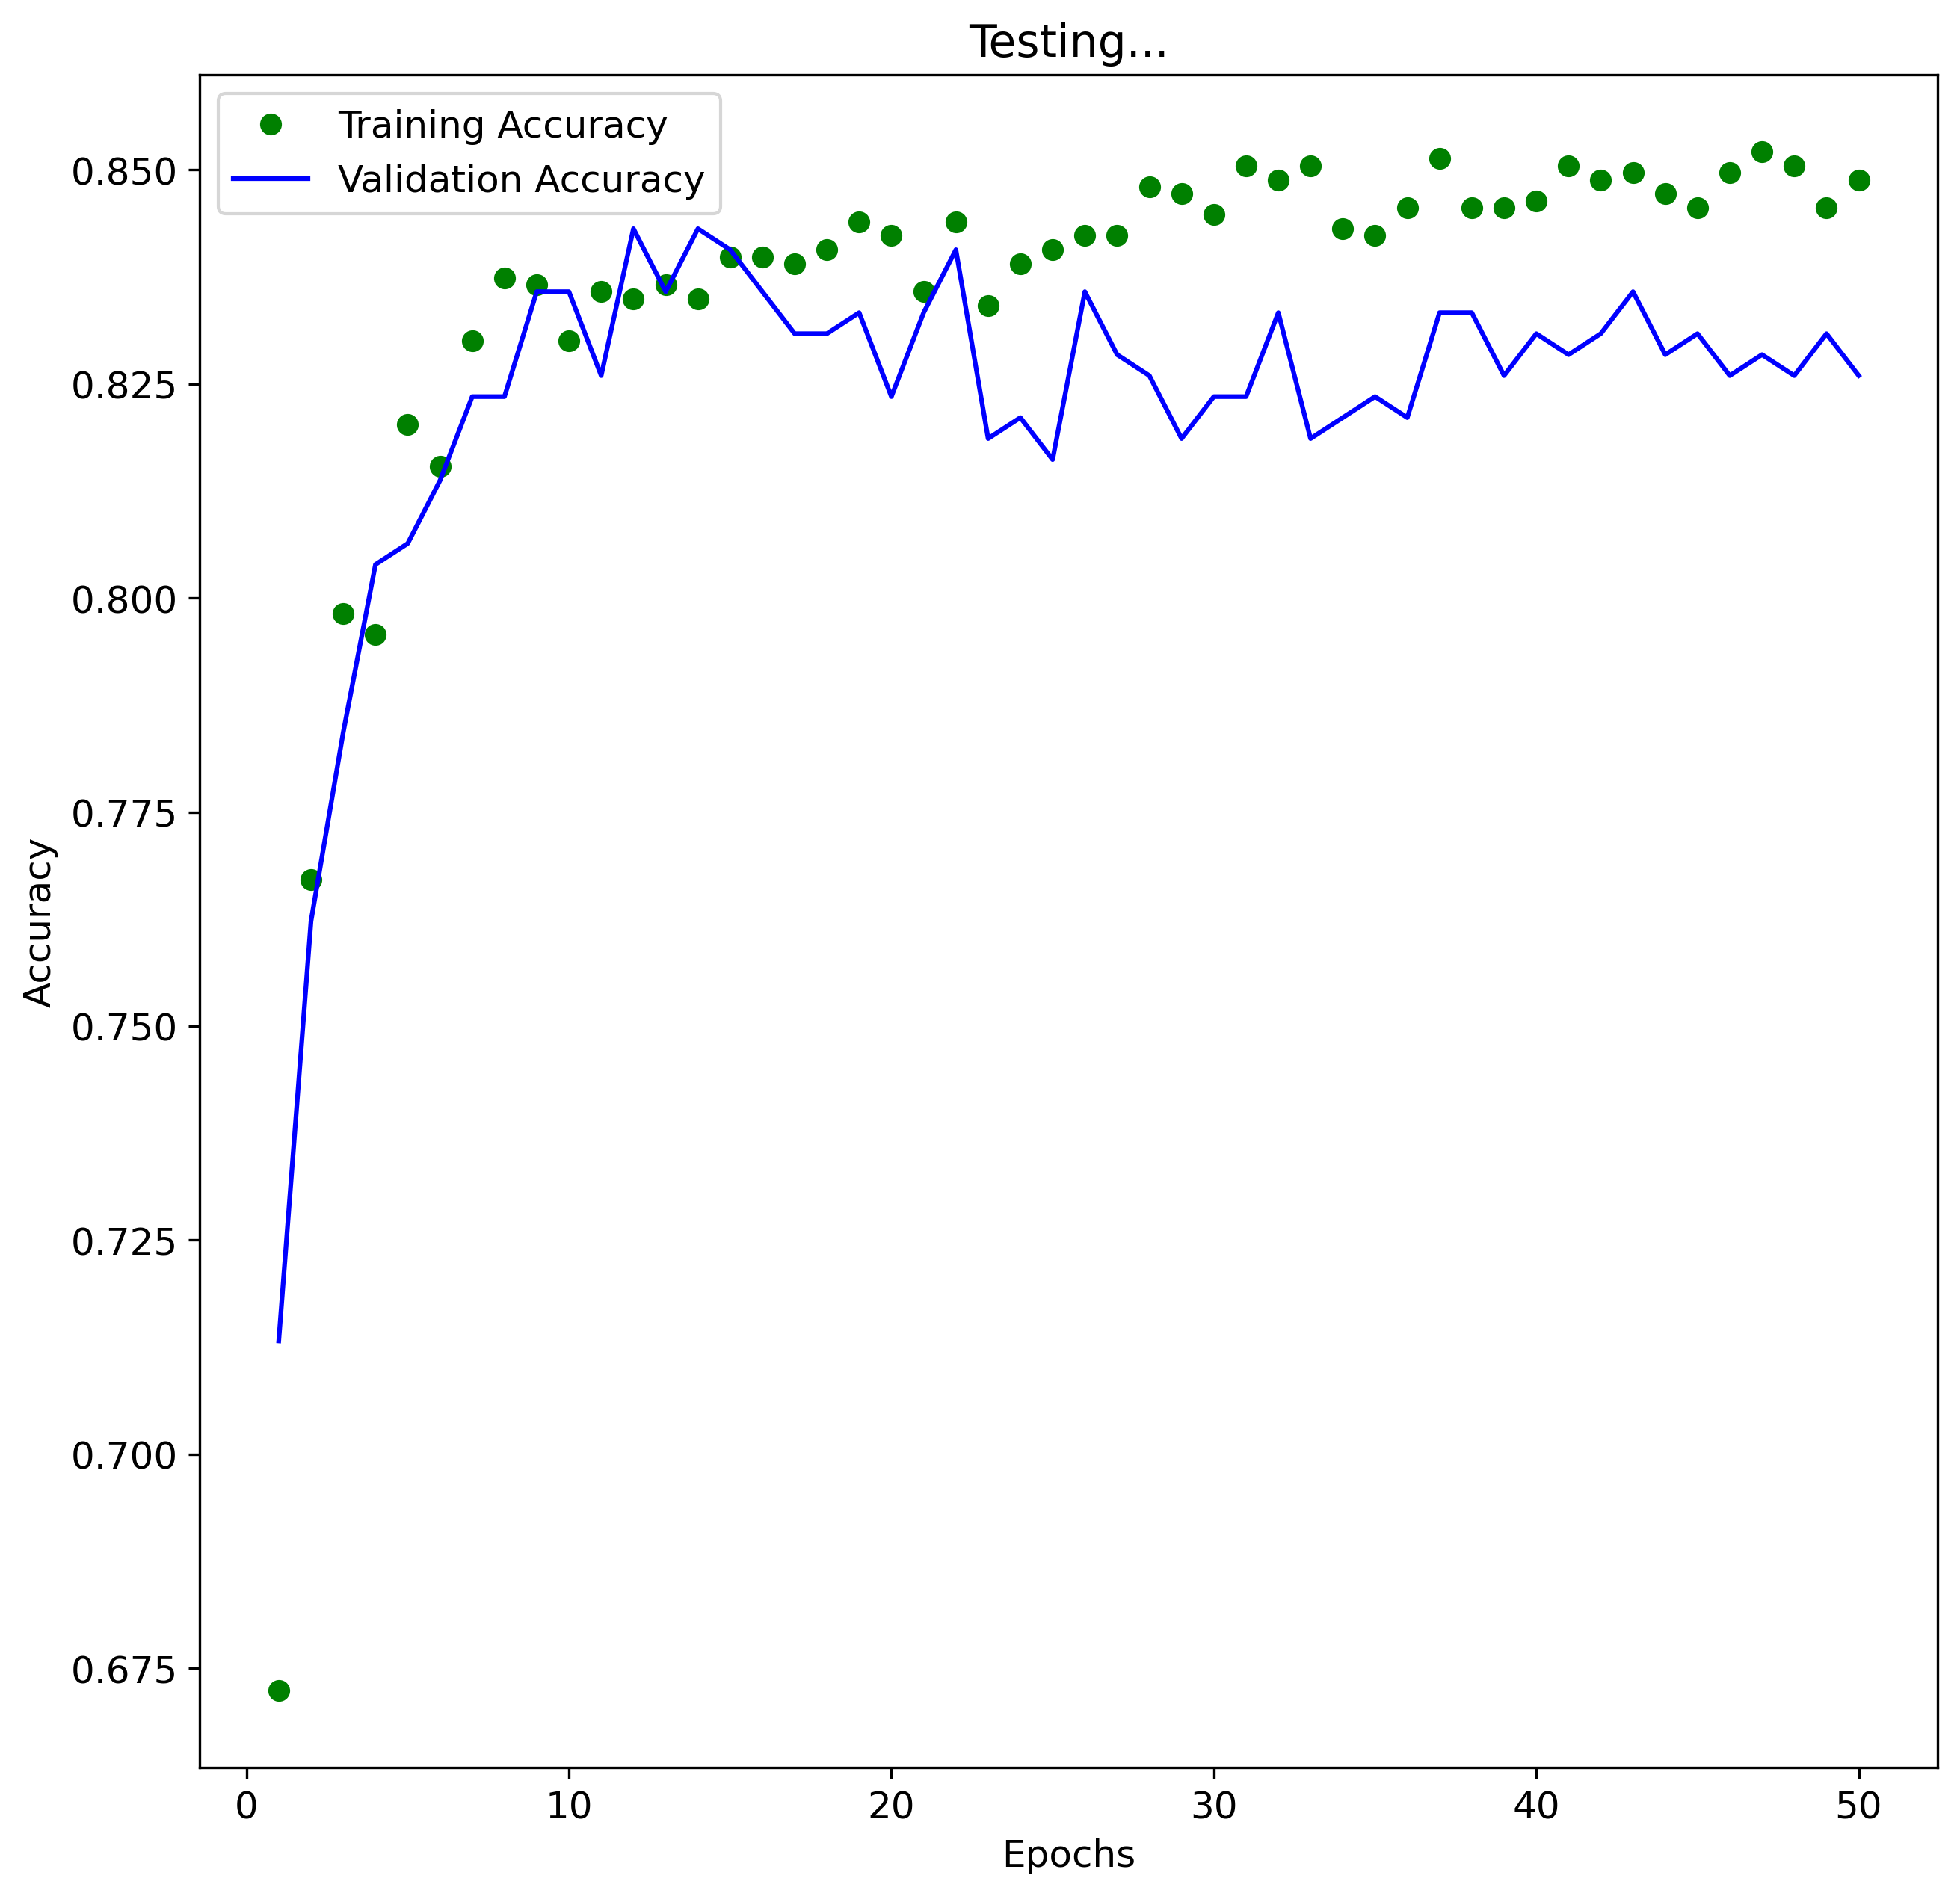

In [19]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']

epochs = range(1, 50 + 1) 

plt.plot(epochs, loss_values, 'go', label = 'Training Accuracy')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Accuracy')

plt.title('Testing...')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

50


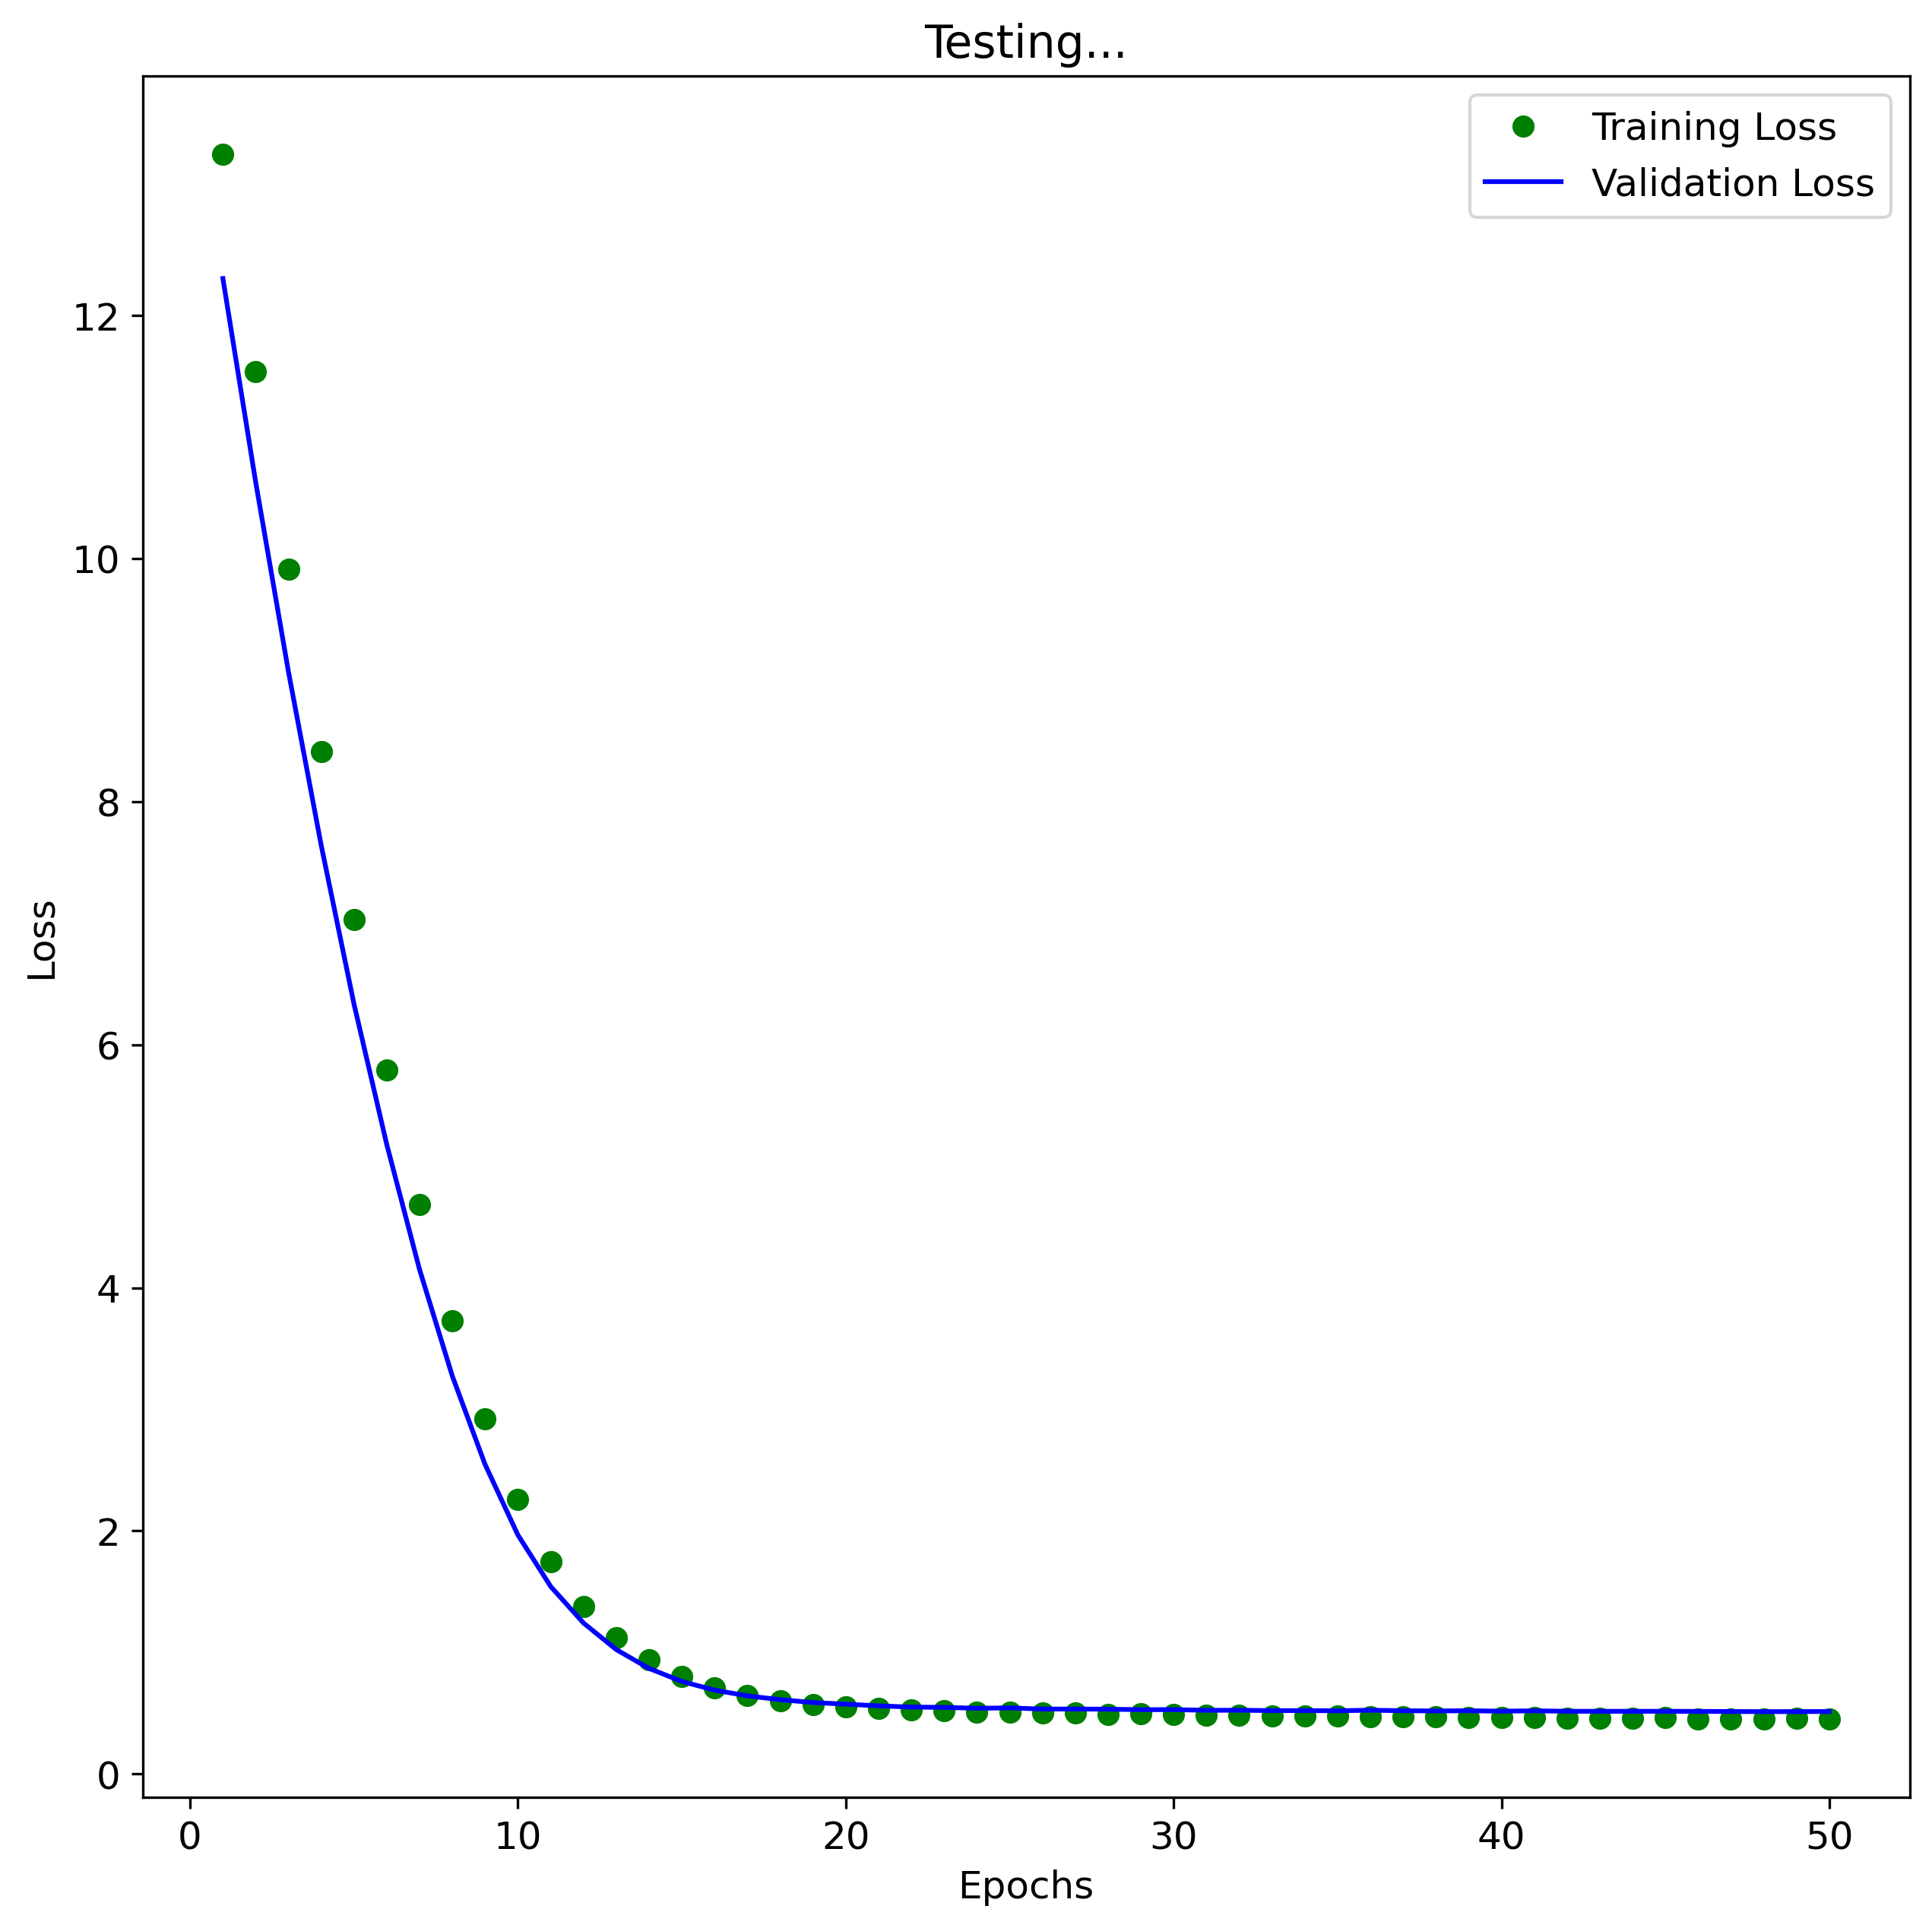

In [20]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
print(len(val_loss_values))

epochs = range(1, 50 + 1)

plt.plot(epochs, loss_values, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')

plt.title('Testing...')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()